In [1]:
from imutils import face_utils
import numpy as np
import pandas as pd
import glob
from natsort import natsorted, ns
import argparse
import imutils
import dlib
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import random
from numba import cuda
import matplotlib as mtplt
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix





In [ ]:
print(len(cuda.gpus))
print(cuda.gpus[0].name)

In [ ]:
# Create list of image names and corresponding gender classifications
image_dic = pd.read_excel('../Datasets/labels_B.xlsx')
image_dic = image_dic[['file_name', 'eye_color']] # Choose columns which are of importance
df = pd.DataFrame(image_dic)
df.to_excel('../Datasets/source_eye_color_B2/labels_B2.xlsx',index=False)

In [ ]:
# Separate different eye colours and corresponding labels into separate folders

# brown = 0
# blue = 1
# green = 2
# grey = 3
# black = 4

source_eye_color = pd.read_excel('../Datasets/source_eye_color_B2/labels_B2.xlsx')
source_images_file_paths = glob.glob ("../Datasets/source_images_B2/*.png") #find all paths which match the given path
source_images_file_paths = natsorted(source_images_file_paths) #sort the list of file names such that the image list will be in the correct order

brown_directory = "../Datasets/sorted_sets_B2/Brown/"
blue_directory = "../Datasets/sorted_sets_B2/Blue/"
green_directory = "../Datasets/sorted_sets_B2/Green/"
grey_directory = "../Datasets/sorted_sets_B2/Grey/"
black_directory = "../Datasets/sorted_sets_B2/Black/"

for file_path in source_images_file_paths:
    image = cv2.imread(file_path, cv2.COLOR_RGB2BGR) #read the image
    image_name = os.path.basename(file_path)
    image_label = source_eye_color[source_eye_color['file_name']==image_name]['eye_color'].iloc[0]
    if(image_label == 0):
        directory = ''.join([brown_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 1):
        directory = ''.join([blue_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 2):
        directory = ''.join([green_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 3):
        directory = ''.join([grey_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    elif(image_label == 4):
        directory = ''.join([black_directory,os.path.basename(image_name)])
        cv2.imwrite(directory, image)
    else:
        print("no label")

In [ ]:

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file

def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/sorted_sets_B2/%s/*.png" %color)
    return files

def get_eyes():    
    for color in eye_colors:
        files = get_files(color)  
        filenumber = 0
        # loop over images
        for (i, file_path) in enumerate(files):
            image = cv2.imread(file_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            detections = detector(gray, 1)
            for k,d in enumerate(detections): #For all detected face instances individually
                # determine the facial landmarks for the face region, then
                # convert the landmark (x, y)-coordinates to a NumPy array
                shape = predictor(gray, d)
                shape = face_utils.shape_to_np(shape)

                # loop over the face parts individually
                #for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():

                # extract the ROI (right eye) of the face region as a separate image
                items = list(face_utils.FACIAL_LANDMARKS_IDXS.items())
                name, (i,j) = items[4] #the 4th item in the FACIAL_LANDMARKS_IDXS is the right eye
                (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
                roi = image[y:y + h, x:x + w]
                out = cv2.resize(roi, (250, 250))
                cv2.imwrite("../Datasets/B2_dataset/%s/%s.jpg" %(color, filenumber), out) #Write image - don't need to worry about keeping track of labels associated because already sorted
                filenumber += 1 #Increment image number
            
# call function
get_eyes() #Call functiona

In [ ]:
# Extracting colours from image



'''
image_path_blk = "../Datasets/B2_dataset/Black/0.jpg"
image_blk = get_image(image_path_blk)

image_path_brn = "../Datasets/B2_dataset/Brown/0.jpg"
image_brn = get_image(image_path_brn)

image_path_blu = "../Datasets/B2_dataset/Blue/1.jpg"
image_blu = get_image(image_path_blu)

image_path_grn = "../Datasets/B2_dataset/Green/0.jpg"
image_grn = get_image(image_path_grn)

image_path_gry = "../Datasets/B2_dataset/Grey/0.jpg"
image_gry = get_image(image_path_gry)

rgb_colors,hex_colors, counts = get_colors(image_blk, number_of_colors, show_chart)
rgb_colors,hex_colors, counts = get_colors(image_brn, number_of_colors, show_chart)
rgb_colors,hex_colors, counts = get_colors(image_blu, number_of_colors, show_chart)
rgb_colors,hex_colors, counts = get_colors(image_grn, number_of_colors, show_chart)
rgb_colors,hex_colors, counts = get_colors(image_gry, number_of_colors, show_chart)'''

# Get features for classification

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def RGB_to_INT(rgb_list):
    temp_hex = []
    temp_int = []
    for color in rgb_list:
        hex_val = RGB2HEX(color)
        int_val = int(hex_val[1:], 16)
        temp_hex.append(hex_val)
        temp_int.append(int_val)
    return temp_int

def RGB2INT(RGB_color): # '#xxxxxx'
    hex_val = RGB2HEX(RGB_color)
    return int(hex_val[1:], 16)

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
    return modified_image

def get_colors(modified_image, number_of_colors, show_chart):    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    counts = Counter(labels)
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    
    if(np.asarray(ordered_colors).shape[0] > 2): # olny if there are 3 clusters formed
        rgb_colors = [ordered_colors[i] for i in counts.keys()]
        hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
        int_colors = [RGB2INT(ordered_colors[i]) for i in counts.keys()]
    else:
        hex_colors = []
        rgb_colors = []
        int_colors = []
        
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
        plt.show()
        
    return rgb_colors, hex_colors , int_colors, counts

def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/B2_dataset/%s/*.jpg" %color)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_features(image):
    features = []
    rgb_colors,hex_colors,int_colors, counts = get_colors(image, number_of_colors, show_chart)
    for color in int_colors:        
        features.append(color)
    return features
        
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for color in eye_colors:
        print("Working on %s" %color)
        training, prediction = get_files(color)
        
        #Append data to training and prediction list, and generate labels 0-4
        for item in training:
            image = get_image(item) #open image
            features = get_features(image)
            if features != []: # checking that there are features to include
                training_data.append(features) #append image array to training data list
                training_labels.append(eye_colors.index(color)) #append image array to training data list 
           
        for item in prediction:
            image = get_image(item)
            features = get_features(image)
            if features != []: # checking that there are features to include
                prediction_data.append(features) #append image array to testing data list
                prediction_labels.append(eye_colors.index(color)) #append image array to testing data list 
          
    return training_data, training_labels, prediction_data, prediction_labels

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors

show_chart = False
number_of_colors = 3

print("Making Sets")
training_data, training_labels, prediction_data, prediction_labels = make_sets()

npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
npar_trainlabs = np.array(training_labels)
npar_pred = np.array(prediction_data)
npar_pred_labels = np.array(prediction_labels)

#train = normalize()
#trainlabs = normalize()
#test = normalize()
#testlabs = normalize()


In [ ]:
#checking stuff
num = 100
start = 0
end = 6190

random_arr = random.sample(range(6190), 100)

print(npar_train.shape)
print(npar_trainlabs.shape)
print(npar_pred.shape)
print(npar_pred_labels.shape)

test_train = [npar_train[i] for i in random_arr] 
test_trainlabs = [npar_trainlabs[i] for i in random_arr]

dataframe = pd.DataFrame(npar_train, columns=['c1','c2','c3'])

plt.scatter(dataframe['c1'].values, dataframe['c2'].values, c = image_labels, cmap = mtplt.colors.ListedColormap(colours))
plt.xlabel('b')
plt.ylabel('g')
plt.show()

plt.scatter(dataframe['b'].values, dataframe['r'].values, c = image_labels, cmap = mtplt.colors.ListedColormap(colours))
plt.xlabel('b')
plt.ylabel('r')
plt.show()

plt.scatter(dataframe['g'].values, dataframe['r'].values, c = image_labels, cmap = mtplt.colors.ListedColormap(colours))
plt.xlabel('g')
plt.ylabel('r')
plt.show()


In [ ]:
# Train classifier

clf = SVC(kernel='rbf')#, verbose = True) #Set the classifier as a support vector machine
print("Training") 
clf.fit(npar_train, npar_trainlabs) #training classifier
print("getting accuracy") #Use score() function to get accuracy

predicted_labels = clf.predict(npar_pred)

pred_lin = clf.score(npar_pred, npar_pred_labels)
print ("Accuracy: ", pred_lin)

In [2]:
eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors

def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/B2_dataset/%s/*.jpg" %color)
    return files

def make_sets():
    image_inputs = []
    image_labels = []
    for color in eye_colors:
        image_files = get_files(color)
        #Append data and generate labels 0-1
        for item in image_files:
            image = cv2.imread(item) #open image
            features = get_features(image)
            image_inputs.append(features) #append image array to training data list
            image_labels.append(eye_colors.index(color))
            
    training_data, prediction_data, training_labels, prediction_labels = train_test_split(image_inputs,image_labels)
    print(len(training_data))
    print(len(training_labels))
    print(len(prediction_data))
    print(len(prediction_labels))
    return training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels

def get_features(image):
    return image.mean(axis=(0,1))

# Run code

training_data, training_labels, prediction_data, prediction_labels, image_inputs, image_labels = make_sets()

6067
6067
2023
2023


In [3]:

dataframe=pd.DataFrame(image_inputs, columns=['b','g','r'])

dataframe["Label"] = image_labels

df_brown = dataframe[dataframe["Label"] == 0]
brown_inputs = df_brown.filter(['b','g','r'], axis=1).values
brown_labels = df_brown.filter(['Label'], axis=1).values

df_blue = dataframe[dataframe["Label"] == 1]
blue_inputs = df_blue.filter(['b','g','r'], axis=1).values
blue_labels = df_blue.filter(['Label'], axis=1).values

df_green = dataframe[dataframe["Label"] == 2]
green_inputs = df_green.filter(['b','g','r'], axis=1).values
green_labels = df_green.filter(['Label'], axis=1).values

df_grey = dataframe[dataframe["Label"] == 3]
grey_inputs = df_grey.filter(['b','g','r'], axis=1).values
grey_labels = df_grey.filter(['Label'], axis=1).values

df_black = dataframe[dataframe["Label"] == 4]
black_inputs = df_black.filter(['b','g','r'], axis=1).values
black_labels = df_black.filter(['Label'], axis=1).values



In [4]:
# Calculate z-score for each class and remove outliers -> something not working properly

z_brown = np.abs(stats.zscore(brown_inputs, axis=1, ddof=1))
z_blue = np.abs(stats.zscore(blue_inputs, axis=1, ddof=1))
z_green = np.abs(stats.zscore(green_inputs, axis=1, ddof=1))
z_grey = np.abs(stats.zscore(grey_inputs, axis=1, ddof=1))
z_black = np.abs(stats.zscore(black_inputs, axis=1, ddof=1))

# set a threshold and find the location where the value meets our condition(s)
threshold = 3

non_outlier_row_loc_brown = []
non_outlier_row_loc_blue = []
non_outlier_row_loc_green = []
non_outlier_row_loc_grey = []
non_outlier_row_loc_black = []

for i, row in enumerate(z_brown):
    keep = all(x < threshold for x in row)
    if(keep):
        non_outlier_row_loc_brown.append(i)

for i, row in enumerate(z_blue):
    keep = all(x < threshold for x in row)
    if(keep):
        non_outlier_row_loc_blue.append(i)
        
for i, row in enumerate(z_green):
    keep = all(x < threshold for x in row)
    if(keep):
        non_outlier_row_loc_green.append(i)
        
for i, row in enumerate(z_grey):
    keep = all(x < threshold for x in row)
    if(keep):
        non_outlier_row_loc_grey.append(i)
        
for i, row in enumerate(z_black):
    keep = all(x < threshold for x in row)
    if(keep):
        non_outlier_row_loc_black.append(i)
        
non_outlier_row_loc_brown = np.asarray(non_outlier_row_loc_brown)
non_outlier_row_loc_blue = np.asarray(non_outlier_row_loc_blue)        
non_outlier_row_loc_green = np.asarray(non_outlier_row_loc_green)        
non_outlier_row_loc_grey = np.asarray(non_outlier_row_loc_grey)        
non_outlier_row_loc_black = np.asarray(non_outlier_row_loc_black)        

#non_outlier_loc_brown = np.where(z_brown < threshold)
#non_outlier_loc_blue = np.where(z_blue < threshold)
#non_outlier_loc_green = np.where(z_green < threshold)
#non_outlier_loc_grey = np.where(z_grey < threshold)
#non_outlier_loc_black = np.where(z_black < threshold)

# find the outlier value given its index
new_brown_inputs_Zscore = np.asarray([brown_inputs[i] for i in non_outlier_row_loc_brown])
new_brown_labels_Zscore = np.asarray([brown_labels[i] for i in non_outlier_row_loc_brown])

new_blue_inputs_Zscore = np.asarray([blue_inputs[i] for i in non_outlier_row_loc_blue])
new_blue_labels_Zscore = np.asarray([blue_labels[i] for i in non_outlier_row_loc_blue])

new_green_inputs_Zscore = np.asarray([green_inputs[i] for i in non_outlier_row_loc_green])
new_green_labels_Zscore = np.asarray([green_labels[i] for i in non_outlier_row_loc_green])

new_grey_inputs_Zscore = np.asarray([grey_inputs[i] for i in non_outlier_row_loc_grey])
new_grey_labels_Zscore = np.asarray([grey_labels[i] for i in non_outlier_row_loc_grey])

new_black_inputs_Zscore = np.asarray([black_inputs[i] for i in non_outlier_row_loc_black])
new_black_labels_Zscore = np.asarray([black_labels[i] for i in non_outlier_row_loc_black])

print(blue_inputs.shape)
print(new_blue_inputs_Zscore.shape)


(1615, 3)
(1607, 3)


C:\Users\herrn\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:2313: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [5]:
# IQR for outliers

df_brown_inputs = pd.DataFrame(brown_inputs, columns=['b','g','r'])
df_blue_inputs = pd.DataFrame(blue_inputs, columns=['b','g','r'])
df_green_inputs = pd.DataFrame(green_inputs, columns=['b','g','r'])
df_grey_inputs = pd.DataFrame(grey_inputs, columns=['b','g','r'])
df_black_inputs = pd.DataFrame(black_inputs, columns=['b','g','r'])

brown_Q1_b = np.quantile(df_brown_inputs['b'].values,0.25)
brown_Q3_b = np.quantile(df_brown_inputs['b'].values,0.75)
brown_IQR_b = brown_Q3_b - brown_Q1_b
brown_Minimum_b = brown_Q1_b - 1.5*brown_IQR_b
brown_Maximum_b = brown_Q3_b + 1.5*brown_IQR_b

brown_Q1_g = np.quantile(df_brown_inputs['g'].values,0.25)
brown_Q3_g = np.quantile(df_brown_inputs['g'].values,0.75)
brown_IQR_g = brown_Q3_g - brown_Q1_g
brown_Minimum_g = brown_Q1_g - 1.5*brown_IQR_g
brown_Maximum_g = brown_Q3_g + 1.5*brown_IQR_g

brown_Q1_r = np.quantile(df_brown_inputs['r'].values,0.25)
brown_Q3_r = np.quantile(df_brown_inputs['r'].values,0.75)
brown_IQR_r = brown_Q3_r - brown_Q1_r
brown_Minimum_r = brown_Q1_r - 1.5*brown_IQR_r
brown_Maximum_r = brown_Q3_r + 1.5*brown_IQR_r

blue_Q1_b = np.quantile(df_blue_inputs['b'].values,0.25)
blue_Q3_b = np.quantile(df_blue_inputs['b'].values,0.75)
blue_IQR_b = blue_Q3_b - blue_Q1_b
blue_Minimum_b = blue_Q1_b - 1.5*blue_IQR_b
blue_Maximum_b = blue_Q3_b + 1.5*blue_IQR_b

blue_Q1_g = np.quantile(df_blue_inputs['g'].values,0.25)
blue_Q3_g = np.quantile(df_blue_inputs['g'].values,0.75)
blue_IQR_g = blue_Q3_g - blue_Q1_g
blue_Minimum_g = blue_Q1_g - 1.5*blue_IQR_g
blue_Maximum_g = blue_Q3_g + 1.5*blue_IQR_g

blue_Q1_r = np.quantile(df_blue_inputs['r'].values,0.25)
blue_Q3_r = np.quantile(df_blue_inputs['r'].values,0.75)
blue_IQR_r = blue_Q3_r - blue_Q1_r
blue_Minimum_r = blue_Q1_r - 1.5*blue_IQR_r
blue_Maximum_r = blue_Q3_r + 1.5*blue_IQR_r

green_Q1_b = np.quantile(df_green_inputs['b'].values,0.25)
green_Q3_b = np.quantile(df_green_inputs['b'].values,0.75)
green_IQR_b = green_Q3_b - green_Q1_b
green_Minimum_b = green_Q1_b - 1.5*green_IQR_b
green_Maximum_b = green_Q3_b + 1.5*green_IQR_b

green_Q1_g = np.quantile(df_green_inputs['g'].values,0.25)
green_Q3_g = np.quantile(df_green_inputs['g'].values,0.75)
green_IQR_g = green_Q3_g - green_Q1_g
green_Minimum_g = green_Q1_g - 1.5*green_IQR_g
green_Maximum_g = green_Q3_g + 1.5*green_IQR_g

green_Q1_r = np.quantile(df_green_inputs['r'].values,0.25)
green_Q3_r = np.quantile(df_green_inputs['r'].values,0.75)
green_IQR_r = green_Q3_r - green_Q1_r
green_Minimum_r = green_Q1_r - 1.5*green_IQR_r
green_Maximum_r = green_Q3_r + 1.5*green_IQR_r

grey_Q1_b = np.quantile(df_grey_inputs['b'].values,0.25)
grey_Q3_b = np.quantile(df_grey_inputs['b'].values,0.75)
grey_IQR_b = grey_Q3_b - grey_Q1_b
grey_Minimum_b = grey_Q1_b - 1.5*grey_IQR_b
grey_Maximum_b = grey_Q3_b + 1.5*grey_IQR_b

grey_Q1_g = np.quantile(df_grey_inputs['g'].values,0.25)
grey_Q3_g = np.quantile(df_grey_inputs['g'].values,0.75)
grey_IQR_g = grey_Q3_g - grey_Q1_g
grey_Minimum_g = grey_Q1_g - 1.5*grey_IQR_g
grey_Maximum_g = grey_Q3_g + 1.5*grey_IQR_g

grey_Q1_r = np.quantile(df_grey_inputs['r'].values,0.25)
grey_Q3_r = np.quantile(df_grey_inputs['r'].values,0.75)
grey_IQR_r = grey_Q3_r - grey_Q1_r
grey_Minimum_r = grey_Q1_r - 1.5*grey_IQR_r
grey_Maximum_r = grey_Q3_r + 1.5*grey_IQR_r

black_Q1_b = np.quantile(df_black_inputs['b'].values,0.25)
black_Q3_b = np.quantile(df_black_inputs['b'].values,0.75)
black_IQR_b = black_Q3_b - black_Q1_b
black_Minimum_b = black_Q1_b - 1.5*black_IQR_b
black_Maximum_b = black_Q3_b + 1.5*black_IQR_b

black_Q1_g = np.quantile(df_black_inputs['g'].values,0.25)
black_Q3_g = np.quantile(df_black_inputs['g'].values,0.75)
black_IQR_g = black_Q3_g - black_Q1_g
black_Minimum_g = black_Q1_g - 1.5*black_IQR_g
black_Maximum_g = black_Q3_g + 1.5*black_IQR_g

black_Q1_r = np.quantile(df_black_inputs['r'].values,0.25)
black_Q3_r = np.quantile(df_black_inputs['r'].values,0.75)
black_IQR_r = black_Q3_r - black_Q1_r
black_Minimum_r = black_Q1_r - 1.5*black_IQR_r
black_Maximum_r = black_Q3_r + 1.5*black_IQR_r

idx_keep_brown = []
idx_keep_blue = []
idx_keep_green = []
idx_keep_grey = []
idx_keep_black = []

for i, row in enumerate(brown_inputs):
    keep = (((row[0] > brown_Minimum_b) and (row[0] < brown_Maximum_b))
            and ((row[1] > brown_Minimum_g) and (row[1] < brown_Maximum_g))
            and ((row[2] > brown_Minimum_r) and (row[2] < brown_Maximum_r)))    
    if(keep):
        idx_keep_brown.append(i)
        
for i, row in enumerate(blue_inputs):
    keep = (((row[0] > blue_Minimum_b) and (row[0] < blue_Maximum_b))
            and ((row[1] > blue_Minimum_g) and (row[1] < blue_Maximum_g))
            and ((row[2] > blue_Minimum_r) and (row[2] < blue_Maximum_r)))    
    if(keep):
        idx_keep_blue.append(i)
        
for i, row in enumerate(green_inputs):
    keep = (((row[0] > green_Minimum_b) and (row[0] < green_Maximum_b))
            and ((row[1] > green_Minimum_g) and (row[1] < green_Maximum_g))
            and ((row[2] > green_Minimum_r) and (row[2] < green_Maximum_r)))    
    if(keep):
        idx_keep_green.append(i)
        
for i, row in enumerate(grey_inputs):
    keep = (((row[0] > grey_Minimum_b) and (row[0] < grey_Maximum_b))
            and ((row[1] > grey_Minimum_g) and (row[1] < grey_Maximum_g))
            and ((row[2] > grey_Minimum_r) and (row[2] < grey_Maximum_r)))    
    if(keep):
        idx_keep_grey.append(i)

for i, row in enumerate(black_inputs):
    keep = (((row[0] > black_Minimum_b) and (row[0] < black_Maximum_b))
            and ((row[1] > black_Minimum_g) and (row[1] < black_Maximum_g))
            and ((row[2] > black_Minimum_r) and (row[2] < black_Maximum_r)))    
    if(keep):
        idx_keep_black.append(i)

        
idx_keep_brown = np.asarray(idx_keep_brown)
idx_keep_blue = np.asarray(idx_keep_blue)
idx_keep_green = np.asarray(idx_keep_green)
idx_keep_grey = np.asarray(idx_keep_grey)
idx_keep_black = np.asarray(idx_keep_black)

new_brown_inputs_IQR = np.asarray([brown_inputs[i] for i in idx_keep_brown])
new_brown_labels_IQR = np.asarray([brown_labels[i] for i in idx_keep_brown])

new_blue_inputs_IQR = np.asarray([blue_inputs[i] for i in idx_keep_blue])
new_blue_labels_IQR = np.asarray([blue_labels[i] for i in idx_keep_blue])

new_green_inputs_IQR = np.asarray([green_inputs[i] for i in idx_keep_green])
new_green_labels_IQR = np.asarray([green_labels[i] for i in idx_keep_green])

new_grey_inputs_IQR = np.asarray([grey_inputs[i] for i in idx_keep_grey])
new_grey_labels_IQR = np.asarray([grey_labels[i] for i in idx_keep_grey])

new_black_inputs_IQR = np.asarray([black_inputs[i] for i in idx_keep_black])
new_black_labels_IQR = np.asarray([black_labels[i] for i in idx_keep_black])


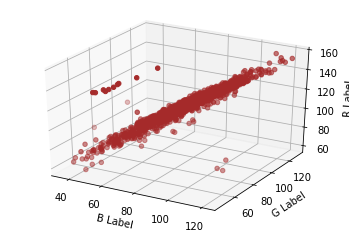

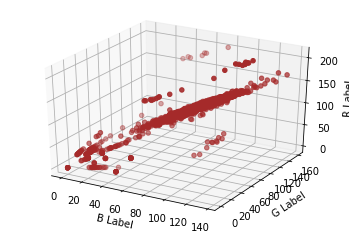

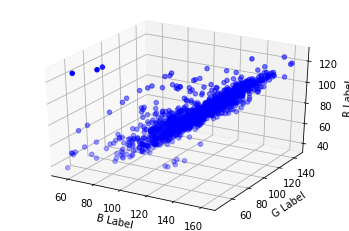

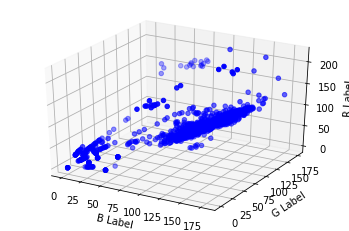

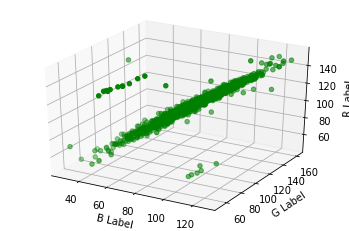

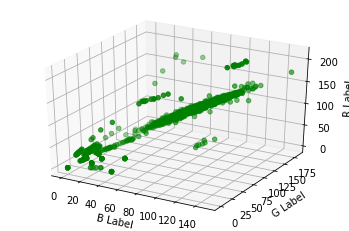

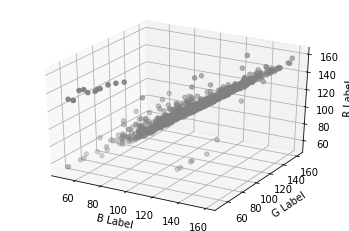

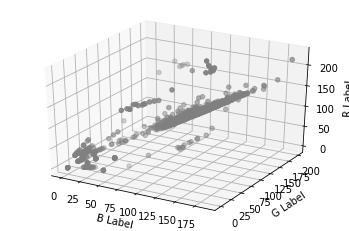

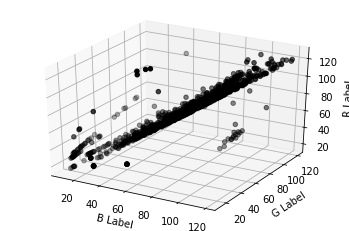

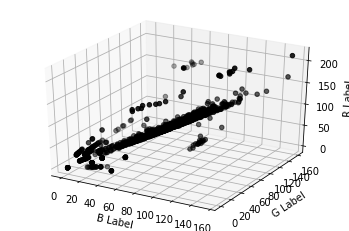

In [6]:
new_df_brown_inputs = pd.DataFrame(new_brown_inputs_IQR, columns=['b','g','r'])
new_df_blue_inputs = pd.DataFrame(new_blue_inputs_IQR, columns=['b','g','r'])
new_df_green_inputs = pd.DataFrame(new_green_inputs_IQR, columns=['b','g','r'])
new_df_grey_inputs = pd.DataFrame(new_grey_inputs_IQR, columns=['b','g','r'])
new_df_black_inputs = pd.DataFrame(new_black_inputs_IQR, columns=['b','g','r'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b1 = new_df_brown_inputs['b'].values
g1 = new_df_brown_inputs['g'].values
r1 = new_df_brown_inputs['r'].values
ax.scatter(b1, g1, r1, c='brown', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b2 = df_brown_inputs['b'].values
g2 = df_brown_inputs['g'].values
r2 = df_brown_inputs['r'].values
ax.scatter(b2, g2, r2, c='brown', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b1 = new_df_blue_inputs['b'].values
g1 = new_df_blue_inputs['g'].values
r1 = new_df_blue_inputs['r'].values
ax.scatter(b1, g1, r1, c='blue', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b2 = df_blue_inputs['b'].values
g2 = df_blue_inputs['g'].values
r2 = df_blue_inputs['r'].values
ax.scatter(b2, g2, r2, c='blue', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b1 = new_df_green_inputs['b'].values
g1 = new_df_green_inputs['g'].values
r1 = new_df_green_inputs['r'].values
ax.scatter(b1, g1, r1, c='green', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b2 = df_green_inputs['b'].values
g2 = df_green_inputs['g'].values
r2 = df_green_inputs['r'].values
ax.scatter(b2, g2, r2, c='green', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b1 = new_df_grey_inputs['b'].values
g1 = new_df_grey_inputs['g'].values
r1 = new_df_grey_inputs['r'].values
ax.scatter(b1, g1, r1, c='grey', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b2 = df_grey_inputs['b'].values
g2 = df_grey_inputs['g'].values
r2 = df_grey_inputs['r'].values
ax.scatter(b2, g2, r2, c='grey', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b1 = new_df_black_inputs['b'].values
g1 = new_df_black_inputs['g'].values
r1 = new_df_black_inputs['r'].values
ax.scatter(b1, g1, r1, c='black', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b2 = df_black_inputs['b'].values
g2 = df_black_inputs['g'].values
r2 = df_black_inputs['r'].values
ax.scatter(b2, g2, r2, c='black', marker='o')
ax.set_xlabel('B Label')
ax.set_ylabel('G Label')
ax.set_zlabel('R Label')

plt.show()

In [7]:
new_image_inputs = np.concatenate((new_brown_inputs_IQR, new_blue_inputs_IQR, new_green_inputs_IQR, new_grey_inputs_IQR, new_black_inputs_IQR))
new_image_labels = np.concatenate((new_brown_labels_IQR, new_blue_labels_IQR, new_green_labels_IQR, new_grey_labels_IQR, new_black_labels_IQR))

print(new_image_inputs.shape)
print(new_image_labels.shape)

new_training_data, new_prediction_data, new_training_labels, new_prediction_labels = train_test_split(new_image_inputs,new_image_labels)

print(new_training_data.shape)
print(new_training_labels.shape)
print(new_prediction_data.shape)
print(new_prediction_labels.shape)

(6920, 3)
(6920, 1)
(5190, 3)
(5190, 1)
(1730, 3)
(1730, 1)


In [8]:
# Training using new data

# Set classifer
clf = SVC(kernel='rbf')

print("Training") 
clf.fit(new_training_data, new_training_labels) #training classifier
print("getting accuracy") #Use score() function to get accuracy
predicted_labels = clf.predict(new_prediction_data)
pred_lin = clf.score(new_prediction_data, new_prediction_labels)
print ("Accuracy: ", pred_lin)
print("Brown, Blue, Green, Grey, Black")
print(confusion_matrix(new_prediction_labels, predicted_labels , labels=[0, 1, 2, 3, 4]))

Training


C:\Users\herrn\Documents\University\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\herrn\Documents\University\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


getting accuracy
Accuracy:  0.9578034682080925
Brown, Blue, Green, Grey, Black
[[336   0  12   0   1]
 [  0 337  14   0   3]
 [  0   0 298   0   1]
 [  2   0  11 326  10]
 [  0   1  15   3 360]]


In [ ]:
# Get features for classification

eye_colors = ["Brown", "Blue", "Green","Grey","Black"] #Define colors

clf = SVC(kernel='linear', probability=True)#, verbose = True) #Set the classifier as a support vector machine


def get_files(color): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("../Datasets/B2_dataset/%s/*.jpg" %color)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_features(image):
    features = []
    #image = cv2.resize(image, (1, 1))
    
    #pixel_b, pixel_g, pixel_r = image[0,0]
    #features.append(pixel_b)
    #features.append(pixel_g)
    #features.append(pixel_r)
    return image.mean(axis=(0,1))
        
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for color in eye_colors:
        print("Working on %s" %color)
        training, prediction = get_files(color)
        #Append data to training and prediction list, and generate labels 0-4
        for item in training:
            image = cv2.imread(item) #open image
            features = get_features(image)
            training_data.append(features) #append image array to training data list
            training_labels.append(eye_colors.index(color))
        for item in prediction:
            image = cv2.imread(item)
            features = get_features(image)
            prediction_data.append(features)
            prediction_labels.append(eye_colors.index(color))
    return training_data, training_labels, prediction_data, prediction_labels

print("Making Sets")
training_data, training_labels, prediction_data, prediction_labels = make_sets()
npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
npar_trainlabs = np.array(training_labels)
print(len(training_labels))
print("Training") 
clf.fit(npar_train, npar_trainlabs) #training classifier
print("getting accuracy") #Use score() function to get accuracy
npar_pred = np.array(prediction_data)
pred_lin = clf.score(npar_pred, prediction_labels)
print ("Accuracy: ", pred_lin)

In [ ]:
print(npar_train)
print(npar_trainlabs)
image = cv2.imread("../Datasets/B2_dataset/Brown/0.jpg")
print(image.mean(axis=(0,1)))